# Fractal Gravity
## Gavin Lucsik

This project explores the hypothetical potential field that arises from a fractal of finite dimension. Fractal's are abstract mathematical objects with very few real-world analogues, thus they are seldom studied in the context of physical phenomena. With this in mind, the findings of this report can be understood from either perspective, mathematically as a mapping of the complex plane to some real space: $\mathbb{C} \rightarrow \mathbb{R}$, or physically as some object with a non-conservative field, $\vec{F}$, such that $\nabla \times \vec{F} \neq 0$. In either case the results confirm the non-newtonian, chaotic structure of the escape-time potential field. 


A fractal is defined such that it's area is finite but it's perimeter is infinitely long, thus to compute a fractal one must approximate the perimeter to a finite degree. This project aims to compute the basins of attraction and repulsion of a Julia set, defined by the logistic map $f_c(z) = z^2 + c$. The escape times of  points $z \in \mathbb{C}$ to define a potential field $U_z$ such that $F = - \nabla U_z$. A point particle is placed within the vicinty of the field to probe the existence of stable states that may emerge from the underlying fractal structure. The particle's motion is found to be non Newtonian and choatic with quasi-stable orbits that emerge and rely heavily on the choice of the parameter $c$. 


## Introduction


In 1966, Mark Kac asked the question, 'Can you hear the shape of a drum?'. Fractal patterns of varying dimension were modeled as the heads of a drum, the surface is subjected to an impulse and then it's resonant eigen-modes are studied. This marked the first instance of a fractal taking a 'physical form' (Lapidus & Niemeyer, 2014). In 2014, the Koch snowflake fractal was modeled as a billard table, simulating billard ball collisions with the inner perimeter and studying how increasing the dimension affects billard behavior (Lapidus & Niemeyer, 2014). 

Drawing inspiration from these studies, one can imbue the fractal itself with physical properties that mimick the real world. This gives rise to a whole class of questions, namely 'What if a fractal were tangible, how would it interact with our world?'. In this study, I examine this question precisely by defining a potential field on a fractal that depends on the escape time of the memebers of the fractal set. The beauty of these sorts of problems lie in the fact that one is free to define the system however they please as the fractal is tied to no physical analogue. Thus the findings of this study are entirely built from self contained definitions and are by no means generalized. 

The fractals used in this study are reffered to a Julia Sets. A julia set is defined topologically as the perimeter separating the points $z \in \mathbb{C}$ that either approach a finite point $p$ (Basin of attraction, $\text{Bas}(p)$) or diverge to infinity (Basin of infinty, $\text{Bas}(\infty)$) under the iterates of the map $f_c$, where $f_c(z) = z^2 + c$.
$$
\text{Bas}(p) : \{ z_{0}\in \mathbb{C}\mid  f^{n}(p) \rightarrow p \} \\
$$
$$
\text{Julia Set} : J(f_{c})=\partial \{ z_{0}\in \mathbb{C}\mid  f^{n}(p) \rightarrow p \} \\
$$
$$
\text{Bas}(\infty) : \{z_{0}\in \mathbb{C}\mid \lim _{n\rightarrow \infty }|f_{c}^{n}(z_{0})| = \infty \} \\
$$

The map $f_c$ is iterated a finite number of times over a grid of points in the complex plane saved in an array. The iteration number at which a point either converges to a point $p$ or diverges to infinity, refered to as the 'escape time', is recorded and it's value is reassigned to that entry in the matrix. The array is decomposed into two separate arrays, $\text{Bas}(\infty)$ & $\text{Bas}(p)$. The escape times are assigned a color based on their magnitude, using a different color scheme for the inner and outer basins. The color assigned to each point in the grid is treated as the magnitude of a potential field $U$ at that point, such that a particle within the vicinty of the fractal will experience a force $F = - \nabla U$. This force is non-conservative as $\nabla \times \vec{F} \neq 0$ thus the behavior of a particle no longer obeys the conservation of energy principle nor Newtonian mechanics. 

## Computational Model


To begin, initialize the following:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from scipy.ndimage import gaussian_filter

In [2]:
res=300
xlim = 2
ylim = 2

The function `julia_set_generator()` take in the parameters `c, xlim, ylim, max_iter` and outputs two matrices `basInftyMatrix`, `bas0Matrix` whose entries are the escape times for each point $z \in \mathbb{C}$ as they converge to $\infty$ & $p$ respectively. The inner structure of $Bas(p)$ is calculated on the ground of Fatou's Theorem on critical points which states that every attracting cycle for a rotational function attracts at least one critical point. For a quadratic polynomial like $f-c(z) = z^2 + c$, the point $z=0$ is the only finite critical point, thus by iterating $f_c(z)$ where $z= 0 + 0i$, we can determine the periodiity of the map for a given value of $c$. Next, each $z$ in our lattice is tested to determine it's rate of convergence, and thus the escape time, to a point in the cycle. It is important to note that throughout the code `bas0` is used in place of `basp` to help distinguish the constrast from `basInfty`. Also recognize that $p=0$ for $c=0$, the trivial case. 

In [3]:
def julia_set_generator(
    c=-1,
    res = res,
    max_iter = 3000,
    xlim = xlim,
    ylim = ylim):
    
    f = lambda x, c: x*x + c
    
    x = np.linspace(-xlim, xlim, res)
    y = np.linspace(-ylim, ylim, res)
    X,Y = np.meshgrid(x,y)
    Z = X + Y*1j
    
    
    def critical_orbit(c, N=5000, burnin=1000):
        z = 0.0 + 0.0j
        orbit = []
        for i in range(N):
            z = z*z + c
            if i >= burnin:
                orbit.append(z)
        return np.array(orbit)

    def detect_cycle(orbit, tol=1e-8, max_period=20):
        # L = len(orbit)
        for p in range(1, max_period + 1):
            diffs = np.abs(orbit[p:] - orbit[:-p])
            if np.all(diffs < tol):
                return p
        return None

    def get_attracting_cycle(c, tol=1e-8):
        orbit = critical_orbit(c)
        p = detect_cycle(orbit, tol=tol)

        if p is None:
            return None

        cycle = orbit[-p:]
        return cycle
    
    bas0 = np.full(Z.shape,max_iter, dtype=int)
    bas02 = np.full(Z.shape,max_iter, dtype=int)
    basInfty = np.full(Z.shape, max_iter, dtype=int)
    basInfty2 = np.full(Z.shape, max_iter, dtype=int)
    Z20 = Z.copy()
    Z2I = Z.copy()
    
    cycle = get_attracting_cycle(c)
    has_cycle = (cycle is not None)
    eps = 1e-6
    
    for i in range(max_iter):
        if has_cycle:
            dist_to_cycle = np.min(np.abs(Z20[..., None] - cycle), axis=-1) #distance to nearest cycle point

            still_far = dist_to_cycle >= eps
            Z20[still_far] = f(Z20[still_far], c)

            just_escaped0 = (bas0 == max_iter) & (~still_far)
            bas0[just_escaped0] = i  #records iteration at which point escapes
            bas02[just_escaped0] = i + 1 - np.log(np.log(np.abs(Z20[just_escaped0])))/np.log(2) #logarithmic scaling of escape time, details here https://en.wikipedia.org/wiki/Julia_set#Pseudocode
        

        basInftyradius = np.abs(Z2I) <= 100*max_iter  #must be greater than max_iter, otehrwise points may escape prematurely
        Z2I[basInftyradius] = f(Z2I[basInftyradius],c)
        just_escapedI = (basInfty == max_iter) & (~basInftyradius) 
        basInfty[just_escapedI] = i  #records iteration at which point escapes
        basInfty2[just_escapedI] = i + 1 - np.log(np.log(np.abs(Z2I[just_escapedI])))/np.log(2) #logarithmic scaling of escape time, details here https://en.wikipedia.org/wiki/Julia_set#Pseudocode
        
    #bas0 matrix
    bas0Matrix = bas0.copy()
    bas0Matrix2 = bas02.copy()

    basInftyMatrix = basInfty.copy()
    tempfilledJuliaSet = (basInftyMatrix == max_iter).astype(int) # temp set to create boolean mask
    basInftyMatrix[tempfilledJuliaSet == 1] = 0 #sets basInfty to 0 inside of Julia set boundary

    basInftyMatrix2 = basInfty2.copy()
    tempfilledJuliaSet = (basInftyMatrix2 == max_iter).astype(int) # temp set to create boolean mask
    basInftyMatrix2[tempfilledJuliaSet == 1] = 0  #sets basInfty to 0 inside of Julia set boundary

    
    ### Optional save (reccomend saving higher resolution matrices for future analysis)###
    # np.save(f'Matrices/bas0c={c}',bas0Matrix)
    # np.save(f'Matrices/basInftyc={c}', basInftyMatrix)
    
    # full_path0 = os.path.join('/Users/g_dog/Desktop/PATH/TO/DIRECTORY', f'bas0c={c}.npy')
    # bas0Matrix = np.load(full_path0)

    # full_pathI = os.path.join('/Users/g_dog/Desktop/PATH/TO/DIRECTORY', f'basInftyc={c}.npy')
    # basInftyMatrix = np.load(full_pathI)
    
    return basInftyMatrix, basInftyMatrix2, bas0Matrix, bas0Matrix2

Some common values of c are provided below, the trivial case is used as a reference point and c=-1 serves as a well structured test. 

In [4]:
# common c values
c=0 #trivial
# c = -1 #bascilla
# c = -0.12256 + 0.74486j #Duoady Rabbit
# c = -1.75 #airplane
# c = -0.75 + 0.11j
# c = -0.835 - 0.321j
# c = 0.3887 - 0.2158j
basInftyMatrix, basInftyMatrix2, bas0Matrix, bas0Matrix2 = julia_set_generator(c=c)

/var/folders/t4/ct669w_n77xbhnyp3_zn65480000gn/T/ipykernel_80357/4191508717.py:63: RuntimeWarning: invalid value encountered in log
  bas02[just_escaped0] = i + 1 - np.log(np.log(np.abs(Z20[just_escaped0])))/np.log(2) #logarithmic scaling of escape time, details here https://en.wikipedia.org/wiki/Julia_set#Pseudocode
/var/folders/t4/ct669w_n77xbhnyp3_zn65480000gn/T/ipykernel_80357/4191508717.py:63: RuntimeWarning: invalid value encountered in cast
  bas02[just_escaped0] = i + 1 - np.log(np.log(np.abs(Z20[just_escaped0])))/np.log(2) #logarithmic scaling of escape time, details here https://en.wikipedia.org/wiki/Julia_set#Pseudocode
/var/folders/t4/ct669w_n77xbhnyp3_zn65480000gn/T/ipykernel_80357/4191508717.py:8: RuntimeWarning: overflow encountered in multiply
  f = lambda x, c: x*x + c
/var/folders/t4/ct669w_n77xbhnyp3_zn65480000gn/T/ipykernel_80357/4191508717.py:8: RuntimeWarning: invalid value encountered in multiply
  f = lambda x, c: x*x + c


The gradient of the potential field is found using `np.gradient()`. Due to the finite nature and limited resolution of the grid, some points in the $U$ matrix are zero as the directional derivative of two consecutive integer points is $0$. Thus if the initial position of the particle (with no initial velocity) happens to be at one of these points, the particle will experience no net force and remain stationary for all iterations. To combat this, a tool from `scipy` is used called `gaussian_filter()`. This applies a slight 'blur' to the matrix elements and ensures non-zero states for each entry, as even $1e^-9$ is sufficient to avoid stationary states when iterating particle motion. Additionally, the net force is a linear combination of the two basin forces, of the form $F_{net} = A F_{Bas(\infty)} + B F_{Bas(0)} $. To determine A and B, a the following sigmoid function is implemented: $\chi_\infty(z) = \frac{1}{1 + e^{-k(U_\infty(z) - T)}}$, where $k$ is an arbitrary tuning parameter that measures the steepness of transition (set to 1), $T$ is the boundary between the two basins, i.e. the Julia Set. This function returns values between 0 and 1 depending on the distance to the boundary, returning $\frac{1}{2}$ at the boundary where both basins contrubute equally. 

In [5]:
k = 1.0 # sharpness of weighted basin contributions 
T = np.percentile(basInftyMatrix2[basInftyMatrix2 > 0], 20)

#weighting parameter for linear combination coefficients A,B: A*F(bas(I)) + B*F(bas(0)) = F_net 
chi_inf = 1 / (1 + np.exp(-k*(basInftyMatrix2 - T)))
chi_0 = 1 - chi_inf

# Basin of infinity
Uinf = gaussian_filter(basInftyMatrix2.astype(float), sigma=1.5 * res / 100)
dUy_inf, dUx_inf = np.gradient(Uinf)
Fx_inf = dUx_inf
Fy_inf = dUy_inf

# Basin of 0
U0 = gaussian_filter(bas0Matrix.astype(float), sigma=1.5 * res/100)
dUy_0, dUx_0 = np.gradient(U0)
Fx_0 = 0.1*dUx_0 
Fy_0 = 0.1*dUy_0 

#scaling 
dx = 2 * xlim / (res - 1)
dy = 2 * ylim / (res - 1)

Fx_inf /= dx #scales forces with increasing resolution, avoids 0's 
Fy_inf /= dy
Fx_0   /= dx
Fy_0   /= dy

# linear combination: A*F(bas(I)) + B*F(bas(0)) = F_net 
Fx_net = chi_inf * Fx_inf + chi_0 * Fx_0 #net forces
Fy_net = chi_inf * Fy_inf + chi_0 * Fy_0


Next, the particle matrix is created, initilaizing the point at some $(x,y)$ in the grid. Because the grid is descretized each point correlates to a specific force value. The position of the particle however is continuous, meaning when in between the grid points the force is ill defined. To fix this, the function `basInftyforce` implements a strategy called bilinear interpolation. For any position of the particle in the grid, the four nearest grid points are weighted based on the particles distance to each one. The linear combination of these weighted values then determines the net force on the particle at that point. 

To actually update the particles position the Euler method is used, storing each entry in a matrix so that the full trajectory is plotted, not just end points. 

In [6]:
pos = np.array([200.0,200.0])   # (x, y) in array coordinates
vel = np.array([0.0, 0.0])   # initial velocity
m = 1.0
dt = 0.5

def basInftyforce(pos, Fx_net, Fy_net): # bilinear interpolation
    x, y = pos
    ny, nx = Fx_net.shape
    i0 = int(np.floor(y))
    j0 = int(np.floor(x))

    i0 = np.clip(i0, 0, ny - 2)
    j0 = np.clip(j0, 0, nx - 2)

    i1 = i0 + 1
    j1 = j0 + 1

    wx = x - j0
    wy = y - i0

    fx = ((1-wx)*(1-wy)*Fx_net[i0, j0] + wx*(1-wy)*Fx_net[i0, j1] +
        (1-wx)*wy*Fx_net[i1, j0] + wx*wy*Fx_net[i1, j1])

    fy = ((1-wx)*(1-wy)*Fy_net[i0, j0] + wx*(1-wy)*Fy_net[i0, j1] +
        (1-wx)*wy*Fy_net[i1, j0] + wx*wy*Fy_net[i1, j1])

    return np.array([fx, fy])

basInftytrajectory = []

ny, nx = Fx_net.shape
for step in range(80*res):
    F = basInftyforce(pos, Fx_net, Fy_net)
    vel += (F / m) * dt
    pos += vel * dt
    pos[0] = np.clip(pos[0], 0, nx - 1.001)
    pos[1] = np.clip(pos[1], 0, ny - 1.001)
    basInftytrajectory.append(pos.copy())
    
Itraj = np.array(basInftytrajectory)

## Results and Discussion

The vector fields of the two basins, the escape times of each point, and the particle trajectory through said field are plotted with `julia_set_plotter_vecfield()`. All values, namely lattice spacing, particle mass, and time are given values of 1 and have not assigned units. If one wishes to assign units to some property of the system all other values can be defined relative to that property and thus the system's proportions can remain unaltered. The behavior of the particle is quite chaotic however for the trivial case where $c=0$, and most cases in which the $Bas(0)$ is simply connected, there is some degree of structure to the particles orbit. Oscillation along the perimeter of the Julia Set are somewhat 'stable', however because of the non-conservative nature of the field, small deviations form this orbit can find the particle subject to massive forces in drastically different directions. 

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
/var/folders/t4/ct669w_n77xbhnyp3_zn65480000gn/T/ipykernel_80357/2920434397.py:4: SyntaxWarning: invalid escape sequence '\i'
  fig.colorbar(imI, ax=ax, label='escape time to $\infty$ ')


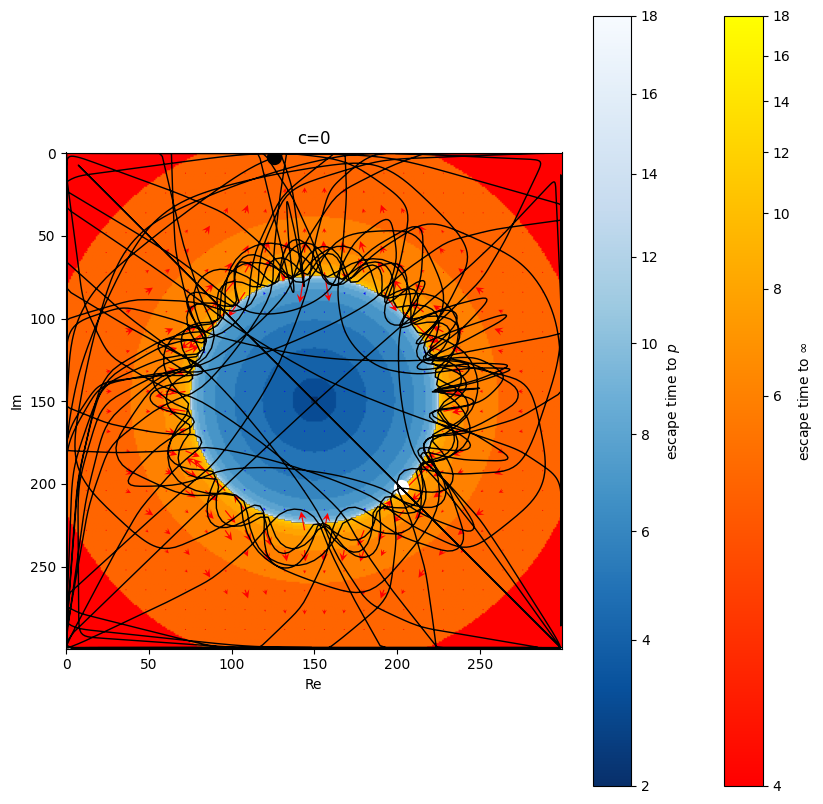

In [7]:
def julia_set_plotter_vecfield():
    fig, ax = plt.subplots(figsize=(10,10))
    imI = ax.imshow(np.ma.masked_where(basInftyMatrix==0,basInftyMatrix),cmap=plt.cm.autumn, norm=colors.PowerNorm(gamma=0.35))
    fig.colorbar(imI, ax=ax, label='escape time to $\infty$ ') 
    im0 = ax.imshow(np.ma.masked_where(basInftyMatrix!=0,bas0Matrix), cmap=plt.cm.Blues_r, norm=colors.PowerNorm(gamma=0.8)) # np.ma.masked_where(basInftyMatrix!=0,bas0Matrix) masks all the points of Bas0 that overlap on non-zero BasInfty points, then plots Bas0 over the BasInfty 0's
    fig.colorbar(im0, ax=ax, label='escape time to $p$ ')


    ny, nx = Fx_net.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    N = 12 # plots every Nth vector

    #Basin Infinity Vector Field
    mask = (basInftyMatrix == 0)
    FIx_masked = np.ma.masked_where(mask, Fx_net)
    FIy_masked = np.ma.masked_where(mask, Fy_net)
    ax.quiver(X[::N, ::N], Y[::N, ::N], FIx_masked[::N, ::N], FIy_masked[::N, ::N], headwidth=7, scale=res/1.2, headlength=7, color='red')

    #Basin 0 Vector Field
    mask = (basInftyMatrix != 0)
    F0x_masked = np.ma.masked_where(mask, dUx_0)
    F0y_masked = np.ma.masked_where(mask, dUy_0)
    ax.quiver(X[::N, ::N], Y[::N, ::N], F0x_masked[::N, ::N], F0y_masked[::N, ::N], headwidth=7, scale=res/2.5, headlength=7, color='blue')

    #trjectory plot
    ax.plot(Itraj[:,0], Itraj[:,1], color='black', linewidth=1)
    plt.scatter(Itraj[0,0], Itraj[0,1], c='white', lw=5) #initial position
    plt.scatter(Itraj[-1, 0], Itraj[-1, 1], c='black', lw=5) #final position

    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.set_title(f'c={c}')
    plt.show()

julia_set_plotter_vecfield()

## Conclusion
The non-conservative nature of the 'escape-time' potential defined in this study leads to non-Newtonian mechanics and highly chaotic behavior. The conservation of energy principle no longer holds for a particle in this system and thus is physically unrealizeable. This system can however serve as a decent approximation of systems in which forces expel energy in a way that is, for all intents and purposes, unrecoverable by the system. These systems can be modeled as experiencing 'non-conservative' forces such that total system energy is not conserved. An example is found in hurricanes and tornados. Either phenomena can be modeled as a highly compressible fluid subject to aperiodic forces. For a particle trapped in such a system, energy is lost as heat and sound vibrations as the particle is tossed about chaotically. This type of motion aligns well with the findings of this study and the geometry of hurricanes and tornaods are approximated by some Julia Sets. 

Works Cited:

Lapidus, M. L., & Niemeyer, R. G. (2014, March 23). The current state of Fractal Billiards. arXiv.org. 	https://doi.org/10.48550/arXiv.1210.0282 

Simonsen, V. P., Hale, N., & Simonsen, I. (2023, September 24). Eigenmodes of fractal drums: A numerical student experiment. arXiv.org. 	https://doi.org/10.48550/arXiv.2309.13613 
